In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 106
model name	: Intel(R) Xeon(R) Platinum 8358P CPU @ 2.60GHz
stepping	: 6
microcode	: 0xd000375
cpu MHz		: 2153.298
cache size	: 49152 KB
physical id	: 0
siblings	: 64
core id		: 0
cpu cores	: 32
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 27
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 invpcid_single ssbd mba ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm rdt_a avx512f avx512dq rd

In [2]:
!cat /proc/meminfo

MemTotal:       791985180 kB
MemFree:        27077692 kB
MemAvailable:   621256268 kB
Buffers:          411208 kB
Cached:         590107996 kB
SwapCached:            0 kB
Active:         518248772 kB
Inactive:       225473392 kB
Active(anon):   153292820 kB
Inactive(anon):   477096 kB
Active(file):   364955952 kB
Inactive(file): 224996296 kB
Unevictable:       18340 kB
Mlocked:           18340 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:                12 kB
Writeback:             0 kB
AnonPages:      153221808 kB
Mapped:          5729780 kB
Shmem:            566524 kB
KReclaimable:    9219080 kB
Slab:           14425496 kB
SReclaimable:    9219080 kB
SUnreclaim:      5206416 kB
KernelStack:       76672 kB
PageTables:       437800 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    395992588 kB
Committed_AS:   290530536 kB
VmallocTotal:   34359738367 kB
VmallocUsed:      673184 kB
VmallocChunk:          0 kB
Percpu

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-e32e60ed-07e2-fc4c-f75c-3971f38b53f5)


In [4]:
!nvidia-smi

Wed Apr 10 02:31:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:9C:00.0 Off |                  N/A |
| 30%   30C    P5    79W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install imutils

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [6]:
import os
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

plt.style.use('ggplot')

from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense
from tensorflow.keras.layers import Reshape
import tensorflow as tf


2024-04-10 02:31:32.306116: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [7]:
os.listdir("/root/covid19-ResNet50/Covid19-dataset")

['test', 'train']

In [8]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super(TransformerEncoderBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

In [9]:
imagePathsTrain = list(paths.list_images("/root/covid19-ResNet50/Covid19-dataset/train"))
trainX = []
trainY = []

for imagePath in imagePathsTrain:

	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	trainX.append(image)
	trainY.append(label)

trainX = np.array(trainX, dtype="float32")
trainY = np.array(trainY)

lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)

In [10]:
imagePathsTest = list(paths.list_images("/root/covid19-ResNet50/Covid19-dataset/test"))
testX = []
testY = []

for imagePath in imagePathsTest:

	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	testX.append(image)
	testY.append(label)

testX = np.array(testX, dtype="float32")
testY = np.array(testY)

lb = LabelEncoder()
testY = lb.fit_transform(testY)
testY = to_categorical(testY)

In [11]:
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.15, random_state=42, stratify=trainY)

In [12]:
print("SHAPE OF TRAIN FEATURES: "+str(trainX.shape))
print("SHAPE OF TRAIN LABELS: "+str(trainY.shape))
print("SHAPE OF VALIDATION FEATURES: "+str(valX.shape))
print("SHAPE OF VALIDATION LABELS: "+str(valY.shape))
print("SHAPE OF TEST FEATURES: "+str(testX.shape))
print("SHAPE OF TEST LABELS: "+str(testY.shape))

SHAPE OF TRAIN FEATURES: (213, 224, 224, 3)
SHAPE OF TRAIN LABELS: (213, 3)
SHAPE OF VALIDATION FEATURES: (38, 224, 224, 3)
SHAPE OF VALIDATION LABELS: (38, 3)
SHAPE OF TEST FEATURES: (66, 224, 224, 3)
SHAPE OF TEST LABELS: (66, 3)


In [13]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [14]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [15]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
#headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Reshape((1, 128))(headModel)
transformerBlock = TransformerEncoderBlock(embed_dim=128, num_heads=4, ff_dim=512)
headModel = transformerBlock(headModel)

#headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = True

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

2024-04-10 02:31:43.603088: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-10 02:31:43.664016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:9c:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2024-04-10 02:31:43.664041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-10 02:31:43.666716: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-10 02:31:43.666789: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-10 02:31:43.667614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [16]:
HR = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(valX, valY),
	validation_steps=len(valX) // BS,
	epochs=EPOCHS)

2024-04-10 02:31:46.136567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-10 02:31:46.155672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz


Epoch 1/20


2024-04-10 02:31:50.770942: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-10 02:31:51.414478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-04-10 02:31:52.198759: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-10 02:31:52.752135: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-10 02:31:53.021017: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 10s 496ms/step - loss: 1.5360 - accuracy: 0.4033 - val_loss: 1.0280 - val_accuracy: 0.3947
Epoch 2/20
6/6 [==============================] - 2s 236ms/step - loss: 0.7420 - accuracy: 0.6906 - val_loss: 0.7587 - val_accuracy: 0.6579
Epoch 3/20
6/6 [==============================] - 2s 254ms/step - loss: 0.4416 - accuracy: 0.8177 - val_loss: 0.6467 - val_accuracy: 0.7105
Epoch 4/20
6/6 [==============================] - 2s 244ms/step - loss: 0.3811 - accuracy: 0.8729 - val_loss: 0.7465 - val_accuracy: 0.6316
Epoch 5/20
6/6 [==============================] - 2s 234ms/step - loss: 0.3705 - accuracy: 0.8564 - val_loss: 0.7101 - val_accuracy: 0.7105
Epoch 6/20
6/6 [==============================] - 2s 252ms/step - loss: 0.2396 - accuracy: 0.9061 - val_loss: 0.4702 - val_accuracy: 0.7895
Epoch 7/20
6/6 [==============================] - 2s 273ms/step - loss: 0.2977 - accuracy: 0.9061 - val_loss: 0.3014 - val_accuracy: 0.8684
Epoch 8/20
6/6 [==============

In [17]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

Accuracy = (accuracy_score(testY.argmax(axis=1),predIdxs)*100)
print('TEST ACCURACY in Percentage:', round(Accuracy,2),'%')
print("")
print("-------------------------------------------------------------------")
print("")
print("CLASSIFICATION REPORT:")
print("")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

TEST ACCURACY in Percentage: 98.48 %

-------------------------------------------------------------------

CLASSIFICATION REPORT:

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       0.95      1.00      0.98        20
Viral Pneumonia       1.00      0.95      0.97        20

       accuracy                           0.98        66
      macro avg       0.98      0.98      0.98        66
   weighted avg       0.99      0.98      0.98        66



In [18]:
model.save('model_resnet50.h5')  

/root/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


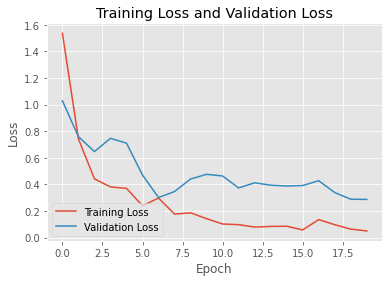

In [19]:
N = EPOCHS

plt.figure()
plt.plot(np.arange(0, N), HR.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), HR.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("LossPlotWMF.png")

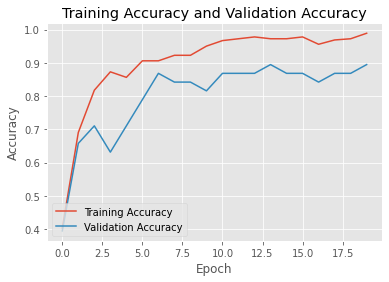

In [20]:
plt.figure()
plt.plot(np.arange(0, N), HR.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N), HR.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("AccuracyPlotWMF.png")